# Multiclass classification on ToN http dataset with encoder clustering

### Imports

In [10]:
import torch
import logging
import os, sys
import joblib

project_root = os.path.abspath(os.path.join(os.getcwd(), '..','..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.utilities.config_manager import ConfigManager
from src.utilities.io_handler import load_data
from src.utilities.dataset_utils import *
from pytorch_tabnet.tab_model import TabNetClassifier
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt


### Configuration

In [11]:
DATASET_CONFIG_PATH = '../../config/ton_config.json'

ConfigManager.load_config(DATASET_CONFIG_PATH)
paths_config = ConfigManager.get_section("paths")
data_cols_config = ConfigManager.get_section("data_columns")

DATA_PATH = '../../resources/dataset/http_ton.csv'
OUTPUT_DIR = paths_config.get("output_dir")
TARGET_COL = data_cols_config.get("target_category_column")
NUMERICAL_COLS = data_cols_config.get("numerical_cols")
CATEGORICAL_COLS = data_cols_config.get("categorical_cols")
RANDOM_STATE = 42    

### Dataset loading and splitting

In [ ]:
df = load_data(DATA_PATH)

keep_cols = CATEGORICAL_COLS + NUMERICAL_COLS + [TARGET_COL]
df = df[keep_cols].copy() 

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE, stratify=df[TARGET_COL])
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_STATE, stratify=temp_df[TARGET_COL])   


### Preprocessing
- StandardScaler per le features numeriche; nonostante TabNet accetti features numeriche raw, normalizzare i dati aumenta le performance del modello

- LabelEncoder per le features categoriche; sarebbe meglio usare OrdinalEncoder, questo è un esperimento. inoltre mappiamo le categorie sconosciute al train set con '_UNK'

In [ ]:
scaler = StandardScaler()
scaler.fit(train_df[NUMERICAL_COLS])
for _df in (train_df, valid_df, test_df):
    _df[NUMERICAL_COLS] = scaler.transform(_df[NUMERICAL_COLS])


categorical_dims, encoders = {}, {}
for col in CATEGORICAL_COLS:
    le = LabelEncoder().fit(train_df[col])
    le.classes_ = np.append(le.classes_, "_UNK")
    train_df[col] = le.transform(train_df[col])
    valid_df[col] = le.transform(
        valid_df[col].where(valid_df[col].isin(le.classes_), "_UNK")
    )
    test_df[col] = le.transform(
        test_df[col].where(test_df[col].isin(le.classes_), "_UNK")
    )
    categorical_dims[col] = len(le.classes_)   
    encoders[col] = le  
y_le = LabelEncoder().fit(train_df[TARGET_COL])
for _df in (train_df, valid_df, test_df):
    _df[TARGET_COL] = y_le.transform(_df[TARGET_COL])

### Some parameters

In [ ]:
unused_feat = [ col for col in df.columns if col not in NUMERICAL_COLS + CATEGORICAL_COLS]

features = [ col for col in df.columns if col not in unused_feat+[TARGET_COL]] 

cat_idxs = [ i for i, f in enumerate(features) if f in CATEGORICAL_COLS]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in CATEGORICAL_COLS]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Used features: {features}")
print(f"Unused features: {unused_feat}")

Used features: ['proto', 'conn_state', 'http_status_code', 'http_user_agent', 'http_method', 'duration', 'dst_bytes', 'missed_bytes', 'src_bytes', 'src_ip_bytes', 'src_pkts', 'dst_pkts', 'dst_ip_bytes', 'http_request_body_len', 'http_response_body_len']
Unused features: ['type']


In [ ]:
X_train = train_df[features].values
y_train = train_df[TARGET_COL].values

X_valid = valid_df[features].values
y_valid = valid_df[TARGET_COL].values

X_test = test_df[features].values
y_test = test_df[TARGET_COL].values

### Model instance

In [ ]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=3,
    input_dim = X_train.shape[1],
    output_dim = len(np.unique(y_train)),
    n_independent=3, n_shared=3,
    gamma=1.8,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=[min(50, dim // 3) for dim in cat_dims], 
    lambda_sparse=1e-3,
    momentum=0.02,
    clip_value=1.5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),  
    scheduler_params={"gamma": 0.95, "step_size": 5},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    epsilon=1e-15, device_name=device
)

/home/mat/tesi_triennale/neural-tabular-intrusion-detection-system/venv/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


#### Computing class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw = cw / cw.mean()
weights_tensor = torch.tensor(cw, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=weights_tensor)

### Model training

In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=150, patience=20,
    batch_size=2048, virtual_batch_size=256,
    loss_fn=loss_fn,
    eval_metric= ['balanced_accuracy'],
    )

epoch 0  | loss: 1.88603 | train_balanced_accuracy: 0.24528 | valid_balanced_accuracy: 0.24321 |  0:02:32s
epoch 1  | loss: 0.71018 | train_balanced_accuracy: 0.2935  | valid_balanced_accuracy: 0.31106 |  0:05:04s
epoch 2  | loss: 0.52797 | train_balanced_accuracy: 0.34202 | valid_balanced_accuracy: 0.31321 |  0:07:38s
epoch 3  | loss: 0.42361 | train_balanced_accuracy: 0.22355 | valid_balanced_accuracy: 0.32621 |  0:10:10s
epoch 4  | loss: 0.33168 | train_balanced_accuracy: 0.27485 | valid_balanced_accuracy: 0.33008 |  0:12:43s
epoch 5  | loss: 0.26219 | train_balanced_accuracy: 0.31005 | valid_balanced_accuracy: 0.31076 |  0:15:16s
epoch 6  | loss: 0.24936 | train_balanced_accuracy: 0.32223 | valid_balanced_accuracy: 0.31491 |  0:17:48s
epoch 7  | loss: 0.21946 | train_balanced_accuracy: 0.33016 | valid_balanced_accuracy: 0.30179 |  0:20:21s
epoch 8  | loss: 0.20712 | train_balanced_accuracy: 0.31901 | valid_balanced_accuracy: 0.28034 |  0:22:55s
epoch 9  | loss: 0.20834 | train_bala

KeyboardInterrupt: 

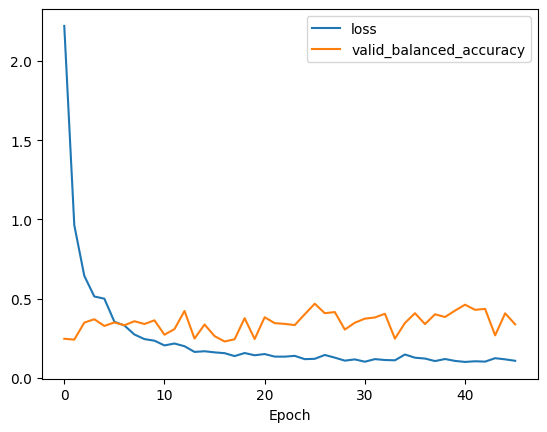

In [ ]:
for metric in ['loss', 'valid_balanced_accuracy']:
    plt.plot(clf.history[metric], label=metric)
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Extracting encoder output

Stiamo prendendo gli output di tutti gli step e li stiamo sommando, esattamente come fa tabnet, senza aggiungere l'utlimo layer lineare che serve a fare previsioni 

In [ ]:
clf.network.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device=clf.device, dtype=torch.float)
    B = 2048  # dimensione batch per l’inferenza
    embs = []
    for i in range(0, X_tensor.size(0), B):
        xb = X_tensor[i:i+B]
        # 1) embedder
        X_emb = clf.network.embedder(xb)
        # 2) encoder
        steps, _ = clf.network.tabnet.encoder(X_emb)
        # 3) somma degli step
        embs.append(torch.sum(torch.stack(steps, dim=0), dim=0).cpu())
    features = torch.cat(embs, dim=0)       # (N_test, n_d)
Z = features.numpy()


### Dimension reduction

In [ ]:
from sklearn.decomposition import PCA
Z_2d = PCA(n_components=2, random_state=42).fit_transform(Z)

### Clustering and plotting

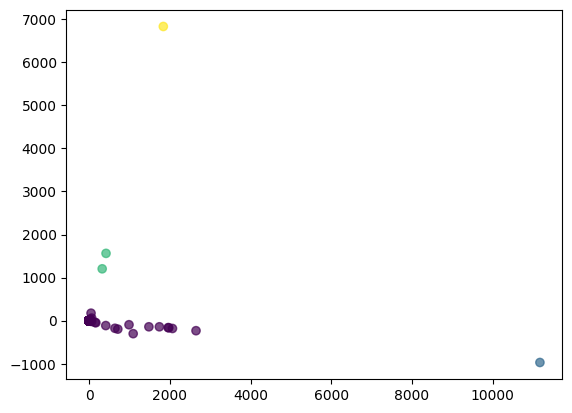

In [ ]:
from sklearn.cluster import KMeans
labels = KMeans(n_clusters=4, random_state=RANDOM_STATE).fit_predict(Z_2d)
plt.scatter(Z_2d[:,0], Z_2d[:,1], c=labels, alpha=0.7)
plt.show()

### Model evaluation

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Balanced Accuracy: {bal_acc:.4f}")
print("Classification Report:\n" + report)
print("Confusion Matrix:\n" + str(cm))

Test Accuracy: 0.3842
Test Balanced Accuracy: 0.4296
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     50614
           1       0.04      0.58      0.07        26
           2       0.16      0.97      0.28     50968
           3       0.00      0.29      0.00         7
           4       0.01      0.01      0.01      9197
           5       0.98      0.00      0.01    189474
           6       0.95      0.91      0.93      4686
           7       0.73      0.68      0.70    211140

    accuracy                           0.38    516112
   macro avg       0.48      0.43      0.25    516112
weighted avg       0.78      0.38      0.33    516112

Confusion Matrix:
[[    90    165  13761   1047   1409      8     70  34064]
 [     0     15      2      7      2      0      0      0]
 [     0      9  49485     26     86      0     18   1344]
 [     0      2      1      2      2      0      0      0]
 [     0      8   8